In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from tqdm import tqdm

/home/mfuai/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_jsonl_data(file_path):
    data = pd.read_json(file_path, lines=True)
    return data

matched_data = load_jsonl_data('/home/mfuai/MSBD5018/dev_matched_sampled-1.jsonl')
mismatched_data = load_jsonl_data('/home/mfuai/MSBD5018/dev_mismatched_sampled-1.jsonl')

nli_data = pd.concat([matched_data, mismatched_data])
nli_data = nli_data.sample(frac=1, random_state=42).reset_index(drop=True)
nli_data = nli_data[nli_data['gold_label'].isin(['contradiction', 'entailment', 'neutral'])]
nli_dataset = Dataset.from_pandas(nli_data)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}
    inputs = []
    labels = []
    for idx, (premise, hypothesis, label) in enumerate(zip(examples['sentence1'], examples['sentence2'], examples['gold_label'])):
        if label not in label_map:
            print(f"Skipping example {idx} with unknown label: {label}")
            continue
        input_text = f"Premise: {premise}\nHypothesis: {hypothesis}\nThe relationship between the premise and the hypothesis is:"
        inputs.append(input_text)
        labels.append(label_map[label])

    encoding = tokenizer(
        inputs,
        truncation=True,
        padding='max_length',
        max_length=512
    )

    encoding['labels'] = labels
    return encoding


encoded_nli_dataset = nli_dataset.map(preprocess_function, batched=True)
train_size = int(0.9 * len(encoded_nli_dataset))
nli_train_dataset = encoded_nli_dataset.select(range(train_size))
nli_eval_dataset = encoded_nli_dataset.select(range(train_size, len(encoded_nli_dataset)))


Map: 100%|██████████| 4924/4924 [00:01<00:00, 3780.14 examples/s]


In [3]:
sample = nli_eval_dataset[5]
print("Sentence 1:", sample['sentence1'])
print("Sentence 2:", sample['sentence2'])
print("Gold Label:", sample['gold_label'])
print("Label:", sample['labels'])

Sentence 1: i guess it's just you know and when i think about that lady this this particular lady who wrote me a check for twelve dollars and it bounced and i sent it through you know sent it through the check through the bank once and she incurred at least a fifteen dollar fee
Sentence 2: The lady incurred a 15 dollar fee when she wrote me a bad 12 dollar check.
Gold Label: entailment
Label: 0


In [5]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=3)
model.to('cuda')
model.config.pad_token_id = tokenizer.eos_token_id

training_args = TrainingArguments(
    output_dir='./gpt2_results',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./gpt2_logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2,
    learning_rate=1e-5,
    warmup_steps=200,
    lr_scheduler_type="cosine"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=nli_train_dataset,
    eval_dataset=nli_eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mfuai/.conda/envs/msbd5018/lib/python3.9/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.121600,1.116994,0.363083,0.409479,0.363083,0.301334
2,1.112700,1.007011,0.523327,0.528414,0.523327,0.524838
3,0.992600,0.944811,0.529412,0.584094,0.529412,0.504345
4,0.929100,0.837065,0.643002,0.657369,0.643002,0.638837
5,0.824300,0.839030,0.636917,0.695083,0.636917,0.632957
6,0.690900,0.846910,0.638945,0.673324,0.638945,0.630791
7,0.721900,0.717967,0.699797,0.697820,0.699797,0.697111
8,0.592600,0.753636,0.685598,0.720104,0.685598,0.682992
9,0.612500,0.713288,0.713996,0.718637,0.713996,0.712186
10,0.497200,0.734304,0.713996,0.726701,0.713996,0.713639


TrainOutput(global_step=2780, training_loss=0.660897816856988, metrics={'train_runtime': 1525.1752, 'train_samples_per_second': 58.105, 'train_steps_per_second': 1.823, 'total_flos': 2.315632711827456e+16, 'train_loss': 0.660897816856988, 'epoch': 20.0})

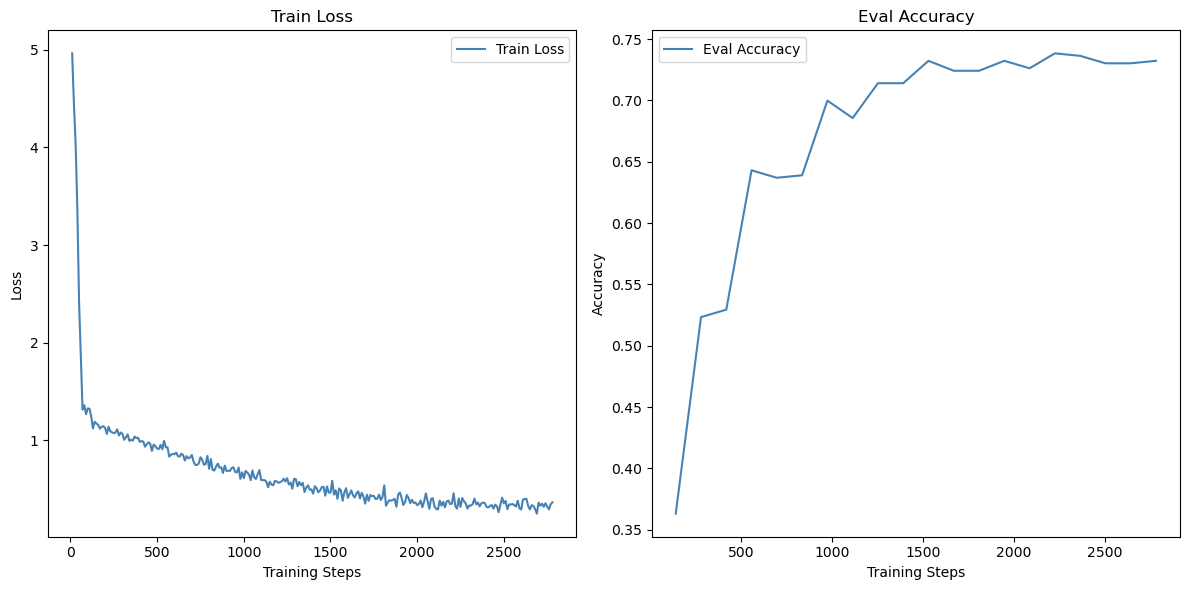

In [8]:
loss_values = []
loss_steps = []
accuracy_values = []
accuracy_steps = []

for log in trainer.state.log_history:
    if 'loss' in log:
        loss_values.append(log['loss'])
        loss_steps.append(log['step'])
    if 'eval_accuracy' in log:
        accuracy_values.append(log['eval_accuracy'])
        accuracy_steps.append(log['step'])

# 创建一个图形，分为两列
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(loss_steps, loss_values, label="Train Loss", color="steelblue")
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(accuracy_steps, accuracy_values, label="Eval Accuracy", color="steelblue")
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Eval Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("gpt2_training_curve.png")
plt.show()

In [ ]:
hal_dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
hal_eval_dataset = hal_dataset['evaluation']

# 标签转换：Non-Factual (1) 和 Factual (0)
def map_labels(label):
    if label in ['major_inaccurate', 'minor_inaccurate']:
        return 1  # Non-Factual
    elif label == 'accurate':
        return 0  # Factual
    return -1  # 处理未知标签的情况

# 获取所需字段
wiki_bio_texts = hal_eval_dataset['wiki_bio_text']
gpt3_sentences = hal_eval_dataset['gpt3_sentences']
annotations = hal_eval_dataset['annotation']

# 新建一个列表来存储处理后的数据
processed_data = []

for wiki_bio_text, gpt3_sentence_list, annotation_list in zip(wiki_bio_texts, gpt3_sentences, annotations):
    # 清理 wiki_bio_text，去除多余的空格或换行符
    wiki_bio_text = wiki_bio_text.replace('\n', ' ').strip()
    
    # 使用 nltk 分割 wiki_bio_text 为多个句子
    try:
        wiki_bio_sentences = nltk.sent_tokenize(wiki_bio_text)
    except Exception as e:
        print(f"Error processing text: {wiki_bio_text[:50]}... Error: {e}")
        continue  # 如果分割出错，跳过此行数据

    # 如果 wiki_bio_sentences 数量大于 gpt3_sentence_list，进行平均分配
    n_sentences = len(gpt3_sentence_list)
    if len(wiki_bio_sentences) > n_sentences:
        # 按块分配每个 gpt3_sentence 到对应的 wiki_bio_sentences
        sentences_per_gpt3 = len(wiki_bio_sentences) // n_sentences
        remainder = len(wiki_bio_sentences) % n_sentences
        
        for i in range(n_sentences):
            start_idx = i * sentences_per_gpt3 + min(i, remainder)
            end_idx = (i + 1) * sentences_per_gpt3 + min(i + 1, remainder)
            combined_wiki_sentences = ' '.join(wiki_bio_sentences[start_idx:end_idx]).strip()
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': combined_wiki_sentences,
                'annotation': annotation_list[i].strip()
            })
    else:
        # 如果句子数相等，则直接一一对应
        for i, wiki_sentence in enumerate(wiki_bio_sentences):
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': wiki_sentence.strip(),
                'annotation': annotation_list[i].strip()
            })


df_processed = pd.DataFrame(processed_data)
df_processed['label'] = df_processed['annotation'].apply(map_labels)

# 将 DataFrame 转换为 Hugging Face Dataset
processed_dataset = Dataset.from_pandas(df_processed)
print(processed_dataset[0])

premises = processed_dataset['wiki_bio_sentences']
hypotheses = processed_dataset['gpt3_sentence']
labels = processed_dataset['label']

{'gpt3_sentence': 'John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.', 'wiki_bio_sentences': 'Sir John Russell Reynolds, 1st Baronet (22 May 1828 – 29 May 1896) was a British neurologist and physician. Reynolds was born in Romsey, Hampshire, as the son of John Reynolds, an independent minister, and the grandson of Dr. Henry Revell Reynolds. He received general education from his father, and was educated in his profession at University College, London, where he obtained three gold medals in the medical school. In 1851, he graduated M.B.', 'annotation': 'major_inaccurate', 'label': 1}


In [9]:
trainer.save_model("./gpt2_prompt_model")
tokenizer.save_pretrained("./gpt2_prompt_model")

results = trainer.evaluate()
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.7132877111434937, 'eval_accuracy': 0.7139959432048681, 'eval_precision': 0.7186371609434226, 'eval_recall': 0.7139959432048681, 'eval_f1': 0.7121859950383813, 'eval_runtime': 1.5726, 'eval_samples_per_second': 313.491, 'eval_steps_per_second': 19.712, 'epoch': 20.0}


In [10]:
hal_dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
hal_eval_dataset = hal_dataset['evaluation']

print(hal_eval_dataset)
print(hal_eval_dataset[0])

Dataset({
    features: ['gpt3_text', 'wiki_bio_text', 'gpt3_sentences', 'annotation', 'wiki_bio_test_idx', 'gpt3_text_samples'],
    num_rows: 238
})
{'gpt3_text': "John Russell Reynolds (1820–1876) was an English lawyer, judge, and author. He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge. He was called to the bar in 1845, and became a Queen's Counsel in 1859. He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.\n\nReynolds was a prolific author, writing on a wide range of topics. He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868). He also wrote on a variety of other topics, including history, biography, and literature. He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorshi

In [11]:
# 标签转换：Non-Factual (1) 和 Factual (0)
def map_labels(label):
    if label in ['major_inaccurate', 'minor_inaccurate']:
        return 1  # Non-Factual
    elif label == 'accurate':
        return 0  # Factual
    return -1  # 处理未知标签的情况

# 获取所需字段
wiki_bio_texts = hal_eval_dataset['wiki_bio_text']
gpt3_sentences = hal_eval_dataset['gpt3_sentences']
annotations = hal_eval_dataset['annotation']

# 新建一个列表来存储处理后的数据
processed_data = []

for wiki_bio_text, gpt3_sentence_list, annotation_list in zip(wiki_bio_texts, gpt3_sentences, annotations):
    # 清理 wiki_bio_text，去除多余的空格或换行符
    wiki_bio_text = wiki_bio_text.replace('\n', ' ').strip()
    
    # 使用 nltk 分割 wiki_bio_text 为多个句子
    try:
        wiki_bio_sentences = nltk.sent_tokenize(wiki_bio_text)
    except Exception as e:
        print(f"Error processing text: {wiki_bio_text[:50]}... Error: {e}")
        continue  # 如果分割出错，跳过此行数据

    # 如果 wiki_bio_sentences 数量大于 gpt3_sentence_list，进行平均分配
    n_sentences = len(gpt3_sentence_list)
    if len(wiki_bio_sentences) > n_sentences:
        # 按块分配每个 gpt3_sentence 到对应的 wiki_bio_sentences
        sentences_per_gpt3 = len(wiki_bio_sentences) // n_sentences
        remainder = len(wiki_bio_sentences) % n_sentences
        
        for i in range(n_sentences):
            start_idx = i * sentences_per_gpt3 + min(i, remainder)
            end_idx = (i + 1) * sentences_per_gpt3 + min(i + 1, remainder)
            combined_wiki_sentences = ' '.join(wiki_bio_sentences[start_idx:end_idx]).strip()
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': combined_wiki_sentences,
                'annotation': annotation_list[i].strip()
            })
    else:
        # 如果句子数相等，则直接一一对应
        for i, wiki_sentence in enumerate(wiki_bio_sentences):
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': wiki_sentence.strip(),
                'annotation': annotation_list[i].strip()
            })


df_processed = pd.DataFrame(processed_data)
df_processed['label'] = df_processed['annotation'].apply(map_labels)

# 将 DataFrame 转换为 Hugging Face Dataset
processed_dataset = Dataset.from_pandas(df_processed)
print(processed_dataset[0])

premises = processed_dataset['wiki_bio_sentences']
hypotheses = processed_dataset['gpt3_sentence']
labels = processed_dataset['label']

{'gpt3_sentence': 'John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.', 'wiki_bio_sentences': 'Sir John Russell Reynolds, 1st Baronet (22 May 1828 – 29 May 1896) was a British neurologist and physician. Reynolds was born in Romsey, Hampshire, as the son of John Reynolds, an independent minister, and the grandson of Dr. Henry Revell Reynolds. He received general education from his father, and was educated in his profession at University College, London, where he obtained three gold medals in the medical school. In 1851, he graduated M.B.', 'annotation': 'major_inaccurate', 'label': 1}


In [12]:
from tqdm import tqdm

tokenizer_pt = GPT2Tokenizer.from_pretrained("./gpt2_prompt_model")
model_pt = GPT2ForSequenceClassification.from_pretrained("./gpt2_prompt_model")
model_pt.to('cuda')

model_pt.eval()

predictions = []

for premise, hypothesis in tqdm(zip(premises, hypotheses), desc="Evaluating"):
   
    encoding = tokenizer_pt(
        premise,
        hypothesis,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
        ).to('cuda')
    
    with torch.no_grad():
        outputs = model_pt(**encoding)

    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    if pred != 0:
        pred = 1
    predictions.append(pred)

accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating: 1795it [00:06, 280.81it/s]

Accuracy: 0.7304
Precision: 0.7308
Recall: 0.9992
F1 Score: 0.8442
